# Implied Volatility and Greeks

Importing required libraries

In [37]:
import math as m
from scipy.stats import norm as n
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

%matplotlib inline

In [12]:
df = pd.read_csv('SPX.csv')
print (df.shape)
df = df.drop_duplicates(subset=['Date','K'],keep='first')
df = df.reset_index(drop=True)
print (df.shape)
print (df.head(10))

(721, 4)
(600, 4)
        Date     T    K   Price
0  3/20/2009  0.07  850    0.45
1  3/20/2009  0.07  875    0.60
2  3/20/2009  0.07  900    0.15
3  3/20/2009  0.07  200  569.80
4  3/20/2009  0.07  300  469.95
5  3/20/2009  0.07  325  444.95
6  3/20/2009  0.07  350  420.05
7  3/20/2009  0.07  375  395.15
8  3/20/2009  0.07  400  370.25
9  3/20/2009  0.07  425  345.35


Considering only the call options for analysis.

In [13]:
S = 770.05      #Stock Price of Google
r = 0.05      #Risk Free Rate
t = df['T']
Price = df['Price']
K = df['K']

Useful functions

#### Black Scholes Merton Model

In [14]:
#Function to calculate the Option price using BSM
def BSMOption(S,K,t,r,sigma,type):
    
    d1 = (np.log(S/K)+(r+((sigma**2)/2))*t)/(sigma*np.sqrt(t))
    d2=d1-sigma*np.sqrt(t)
    
    if (type=='c'):    
        C = S*n.cdf(d1)-(K*np.exp(-r*t)*n.cdf(d2))
        return C
    else:    
        P = K*np.exp(-r*t)*n.cdf(-d2)-S*n.cdf(-d1)
        return P

### Root Finding Methods

#### Bisection Method

In [15]:
#Calculating the implied Volatility using the Bisection Method
def bisect(S,K,r,t,types,MP):
    time1 = datetime.now()
    a = 0.0001       #Minimum Value
    b = 1       #Maximum Value
    N = 1       #Number of iterations
    tol = 10**-4
    
    f = lambda s:BSMOption(S,K,t,r,s,types)-MP         
    
    while N<=100:
        sig = (a+b)/2.0
        if f(sig)==0 or (b-a)/2<tol:
            time2 = datetime.now()
            t = time2-time1
            return sig
        N = N + 1
        if np.sign(f(sig))==np.sign(f(a)):
            a = sig
        else:
            b = sig
    print ("Did not converge")
    

#### Secant Method

This method is slightly faster than Newton method since there is no need to calculate the vega of the derivative which might sometimes be impossible to calculate. This is where we could use a Numerical approximation in Finite difference method.

In [16]:
#Calculating the implied Volatility using the Secant Method
def secant(S,K,r,t,types,MP):
    time1 = datetime.now()
    x0 = 0.1
    xx = 1
    tolerance = 10**-7
    epsilon = 10**(-14)
    
    maxIterations = 100
    SolutionFound = False
    
    #Anonymous function to calculate the Implied volatility using the Secant Method
    f = lambda s:BSMOption(S,K,t,r,s,types)-MP         
    
    for i in range(maxIterations):
        y = f(x0)
        yprime = (f(x0)-f(xx))/(x0-xx)      
        
        if (abs(yprime)<epsilon):
            break
        
        x1 = x0 - y/yprime
        
        if (abs(x1-x0)<=tolerance*abs(x1)):
            SolutionFound = True
            break
        
        x0 = x1
    
    if (SolutionFound):
        time2 = datetime.now()
        t = time2 - time1
        return x1
    else:
        pass

#### Newton Method

It is faster than the Bisection method but to converge quickly, there is a need to make an approximate guess.

In [17]:
#Calculating the implied Volatility using the Newton Method
def newton(S,K,r,t,types,MP):
    time1 = datetime.now()
    x0 = 1
    maxIterations =100
    
    epsilon = 10**-14
    tolerance = 10**-7
    solutionFound = False
    #Anonymous function to calculate the Implied volatility using the Newton Method
    f = lambda s:BSMOption(S,K,t,r,s,types)-MP  
    
    fprime = lambda sig:S*np.sqrt(t)*(1/np.sqrt(2*np.pi))*np.exp((-((np.log(S/K)+(r+((sig**2)/2))*t)/(sig*np.sqrt(t)))**2)/2)
    
    for i in range(maxIterations):
        
        y = f(x0)
        vega = fprime(x0)
        
        if (abs(vega)<epsilon):
            break
        
        x1 = x0 - y/vega
        if (abs(x1-x0)<=tolerance*abs(x1)):
            solutionFound = True
            break
        x0=x1
    
    if (solutionFound):
        time2 = datetime.now()
        t = time2 - time1
        return x1
    else:
        pass 
        

Calculating the implied vols using all the 3 above methods

In [18]:
volb = [];vols=[];voln=[];bsm =[];
#Loop over options in the CSV file
for i in range(0,len(K)):
    volb.append(bisect(S,K.iloc[i],r,t.iloc[i],'c',Price.iloc[i]))
    bsm.append(BSMOption(S,K.iloc[i],t.iloc[i],r,volb[i],'c'))
    vols.append(secant(S,K.iloc[i],r,t.iloc[i],'c',Price.iloc[i]))
    voln.append(newton(S,K.iloc[i],r,t.iloc[i],'c',Price.iloc[i]))

In [19]:
#Showcasing the values
df1 = pd.DataFrame({'Date':t,'K':K,'Bisection':volb,'Secant':vols,'Newton':voln,'MP':Price,'BSM':bsm})
df1.to_csv('vols_using_roots.csv',index=False)

In [20]:
df1.head(15)

,Date,K,Bisection,Secant,Newton,MP,BSM
0,0.07,850,0.189717,0.189712,0.189712,0.45,0.450073
1,0.07,875,0.247695,0.247752,0.247752,0.60,0.599176
2,0.07,900,0.241348,NaN,0.241362,0.15,0.149927
3,0.07,200,0.999939,NaN,NaN,569.80,570.748779
4,0.07,300,0.999939,NaN,NaN,469.95,471.103585
5,0.07,325,0.999939,NaN,NaN,444.95,446.203933
6,0.07,350,0.999939,NaN,NaN,420.05,421.326020
7,0.07,375,0.999939,NaN,NaN,395.15,396.494217
8,0.07,400,0.999939,NaN,NaN,370.25,371.749258
9,0.07,425,0.999939,NaN,NaN,345.35,347.152296


The NaNs are due to the Market Price being smaller than the Theoretical Price (Black Scholes price).

### Volatility Smile

In [38]:
vols = pd.read_csv('vols_using_roots.csv',index_col=['Date'])
#Dropping nans
vols.dropna(inplace=True)
vols.head()

,K,Bisection,Secant,Newton,MP,BSM
Date,,,,,,
0.07,850,0.189717,0.189712,0.189712,0.45,0.450073
0.07,875,0.247695,0.247752,0.247752,0.60,0.599176
0.07,550,0.514636,0.514623,0.514623,222.15,222.150038
0.07,560,0.549178,0.549174,0.549174,212.45,212.450028
0.07,575,0.564680,0.564731,0.564731,197.95,197.949489


In [39]:
vols = vols.sort_values(by=['Date','K','Newton'],ascending=[True,True,True])
vols.head()

,K,Bisection,Secant,Newton,MP,BSM
Date,,,,,,
0.07,550,0.514636,0.514623,0.514623,222.15,222.150038
0.07,560,0.549178,0.549174,0.549174,212.45,212.450028
0.07,575,0.564680,0.564731,0.564731,197.95,197.949489
0.07,580,0.567487,0.567483,0.567483,193.15,193.150043
0.07,590,0.573712,0.573712,0.573712,183.65,183.650002


In [40]:
vols = vols[(vols['K']>600) & (vols['K']<1200)]

#### 2- D Plot

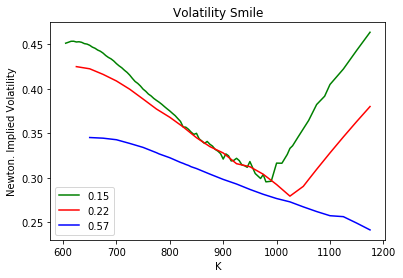

In [41]:
#Aggregate
plt.plot(vols.loc[0.15]['K'],vols.loc[0.15]['Newton'],'g')
plt.plot(vols.loc[0.22]['K'],vols.loc[0.22]['Newton'],'r')
plt.plot(vols.loc[0.57]['K'],vols.loc[0.57]['Newton'],'b')
plt.xlabel("K")
plt.ylabel("Newton. Implied Volatility")
plt.title("Volatility Smile")
plt.legend([0.15,0.22,0.57])

plt.savefig('Volatility Smile.png')

#### 3- D Plot

In [46]:
vols = vols.loc[[0.15,0.22,0.57]]
vols.index.unique()

Float64Index([0.15, 0.22, 0.57], dtype='float64', name='Date')

Text(0.5, 0, 'Implied Vol')

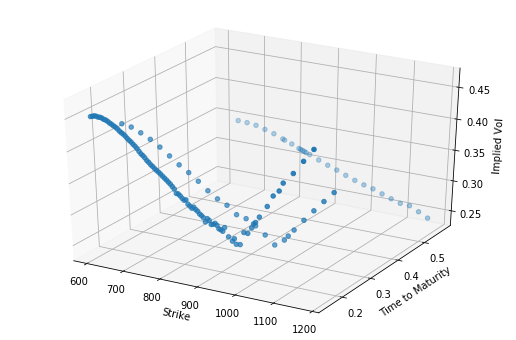

In [52]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
d3 = ax.scatter(vols['K'],vols.index,vols['Newton'],s=20,c=None,depthshade=True)

ax.set_xlabel('Strike')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Implied Vol')

### Greeks

Greeks are measures which can tell the sensitivity of an option's price based on different factors.


$
Delta:\Delta = \partial C / \partial S
\\ Gamma: \gamma = \partial^2 C / \partial S^2
\\ Vega: \nu = \partial C / \partial \sigma
$

#### Analytical Solution

In [71]:
#Greeks using the Analytical Formula       
def Greeks(S,K,t,r,sigma):
    d1 = (m.log(S/K)+(r+(sigma**2/2))*t)/(sigma*m.sqrt(t))
    NDashd1 = (1/m.sqrt(2*m.pi))*m.exp((-d1**2)/2) 
    Delta = n.cdf(d1)
    Gamma = NDashd1/(S*sigma*m.sqrt(t))
    Vega = S*m.sqrt(t)*NDashd1
    return Delta,Gamma,Vega

In [56]:
greeks = []
for i in range(vols.shape[0]):
    greeks.append(Greeks(S,vols['K'].iloc[i],vols.index[i],r,vols['Newton'].iloc[i]))

In [63]:
analytical_df = pd.DataFrame(greeks)
analytical_df.columns = ['Delta','Gamma','Vega']
analytical_df.head()

,Delta,Gamma,Vega
0,0.954890,0.000816,19.349468
1,0.949995,0.000889,21.014139
2,0.945056,0.000963,22.645727
3,0.939441,0.001044,24.446562
4,0.933769,0.001126,26.210948


#### Finite difference approximations

Although there is no need of the approximations method since we have a closed form solutions for the Greeks. It is slightly faster and sometimes speed might be more important than the exact solution.

In [65]:
#Greeks using the FDM Approximations
def GreeksFDM(S,K,t,r,sigma):
    
    #price and sigma increment
    d_s = 0.001
    
    CDelta = (BSMOption(S+d_s,K,t,r,sigma,'c') -BSMOption(S,K,t,r,sigma,'c'))/d_s
    
    CGamma = (BSMOption(S+d_s,K,t,r,sigma,'c') -2*BSMOption(S,K,t,r,sigma,'c')+BSMOption(S-d_s,K,t,r,sigma,'c'))/(d_s**2)
    
    CVega = (BSMOption(S,K,t,r,sigma+d_s,'c') -BSMOption(S,K,t,r,sigma,'c'))/d_s
    
    return CDelta,CGamma,CVega

In [66]:
greeks = []
for i in range(vols.shape[0]):
    greeks.append(GreeksFDM(S,vols['K'].iloc[i],vols.index[i],r,vols['Newton'].iloc[i]))

In [67]:
fdm_df = pd.DataFrame(greeks)
fdm_df.columns = ['Delta','Gamma','Vega']
fdm_df.head()

,Delta,Gamma,Vega
0,0.954890,0.000816,19.393717
1,0.949995,0.000889,21.059462
2,0.945056,0.000963,22.692015
3,0.939441,0.001044,24.493584
4,0.933770,0.001126,26.258601
